In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import random

In [2]:
# Composite DP Mechanism (1) [https://github.com/CompositeDP/CompositeDP]

def float3f(num):
    return float(format(num, '.3f'))


def float2f(num):
    return float(format(num, '.2f'))


# Constraints

def LValue(ep, k, m, y):
    return (1 - k * m) / (2 * y)

def aValue(ep, k, m, y, Cp):
    return (2 * Cp - k * m ** 2) / (2 * k * m)

def checkConstraints(ep, k, m, y, Cp):
    if k <= 0:
        return -1
    if m <= 0:
        return -2
    if y <= 0:
        return -3

    L = LValue(ep, k, m, y)
    a = aValue(ep, k, m, y, Cp)

    if k * m >= 1:
        return -4
    if (Cp > k * m * (2 * L - m) / 2) or (Cp < -k * m * (2 * L - m) / 2):
        return -5
    if k > 1 - y:
        return -6
    if k > y * (np.e ** ep - 1):
        return -7
    
    return 0


# Mapping

def range_Cp_fun(ep, k, m, y):
    L = LValue(ep, k, m, y)
    return k * m * (2 * L - m)

def mapping_fromRealToL(input_value, range_f, lower, ep, k, m, y):
    L = LValue(ep, k, m, y)
    range_Cp = range_Cp_fun(ep, k, m, y)
    C = range_Cp / range_f
    mapped_value = (input_value - lower) * C - L

    return mapped_value

def mapping_inverse_fromLToReal(input_value, range_f, lower, ep, k, m, y):
    L = LValue(ep, k, m, y)
    range_Cp = range_Cp_fun(ep, k, m, y)
    C = range_Cp / range_f
    mapped_inverse_value = (input_value + L) / C + lower

    return mapped_inverse_value

def listmapping_inverse_fromLToReal(input_list, range_f, lower, ep, k, m, y):
    mapped_inverse_list = []
    for i in range(len(input_list)):
        tmp = mapping_inverse_fromLToReal(input_list[i], range_f, lower, ep, k, m, y)
        mapped_inverse_list.append(tmp)
    return mapped_inverse_list


# Parameter Optimization

def reduceRate(var1, var2):
    rate = (var1 - var2) / var1
    return float(rate)

def H1Rate(ep, k, m, y):
    L = LValue(ep, k, m, y)
    S1 = k*m; S2 = 2*L*y
    return float(S2 / S1)

def H2Rate(Cp, ep, k, m, y):
    L = LValue(ep, k, m, y)
    return 0.33333

def theory_var_fun(ep, k, m, y, Cp_assume):
    Cp = Cp_assume
    L = LValue(ep, k, m, y)
    a = aValue(ep, k, m, y, Cp)
    variance = -Cp ** 2 + 2 * L ** 3 * y / 3 + a ** 2 * k * m + a * k * m ** 2 + k * m ** 3 / 3
    return float(variance)

def parameter_optimization(ep):
    step1 = 0.1
    step2 = 0.01
    step3 = 0.001
    k_best = 0
    m_best = 0
    y_best = 0
    reduceRate_best = -1000

    y_upper = 1
    k_upper = 1
    m_upper = 2

    # First round step1
    y_count = 0
    while (y_count < y_upper):
        k_count = 0
        while (k_count < k_upper):
            m_count = 0
            while (m_count <= m_upper):
                if y_count == 0:
                    m_count = m_count + step1
                    continue
                range_Cp = range_Cp_fun(ep, k_count, m_count, y_count)
                # Cp_assume = range_Cp / 2
                Cp_assume = 0
                if (checkConstraints(ep, k_count, m_count, y_count, Cp_assume) == 0):
                    var_tmp = theory_var_fun(ep, k_count, m_count, y_count, Cp_assume)
                    var_lap = (range_Cp / ep) ** 2 * 2
                    reduceRate_tmp = reduceRate(var_lap, var_tmp)

                    if (reduceRate_tmp > reduceRate_best):
                        reduceRate_best = reduceRate_tmp
                        k_best = k_count
                        m_best = m_count
                        y_best = y_count

                m_count = m_count + step1
            k_count = k_count + step1
        y_count = y_count + step1

    # Second round step2
    if (y_best == 0):
        y_count = 0
        y_count_end = 0.1
    else:
        y_count = y_best - step1
        y_count_end = y_best + step1
    while (y_count < y_count_end):
        if (k_best == 0):
            k_count = 0
            k_count_end = 0.1
        else:
            k_count = k_best - step1
            k_count_end = k_best + step1
        while (k_count < k_count_end):
            if (m_best == 0):
                m_count = 0
                m_count_end = 0.1
            else:
                m_count = m_best - step1
                m_count_end = m_best + step1
            while (m_count < m_count_end):
                if y_count == 0:
                    m_count = m_count + step2
                    continue
                range_Cp = range_Cp_fun(ep, k_count, m_count, y_count)
                # Cp_assume = range_Cp / 2
                Cp_assume = 0
                if (checkConstraints(ep, k_count, m_count, y_count, Cp_assume) == 0):
                    var_tmp = theory_var_fun(ep, k_count, m_count, y_count, Cp_assume)
                    var_lap = (range_Cp / ep) ** 2 * 2
                    reduceRate_tmp = reduceRate(var_lap, var_tmp)

                    if (reduceRate_tmp > reduceRate_best):
                        reduceRate_best = reduceRate_tmp
                        k_best = k_count
                        m_best = m_count
                        y_best = y_count

                m_count = m_count + step2
            k_count = k_count + step2
        y_count = y_count + step2

    # Third round step3
    if (y_best == 0):
        y_count = 0
        y_count_end = 0.01
    else:
        y_count = y_best - step2
        y_count_end = y_best + step2
    while (y_count < y_count_end):
        if (k_best == 0):
            k_count = 0
            k_count_end = 0.01
        else:
            k_count = k_best - step2
            k_count_end = k_best + step2
        while (k_count < k_count_end):
            if (m_best == 0):
                m_count = 0
                m_count_end = 0.01
            else:
                m_count = m_best - step2
                m_count_end = m_best + step2
            while (m_count < m_count_end):
                if y_count == 0:
                    m_count = m_count + step3
                    continue
                range_Cp = range_Cp_fun(ep, k_count, m_count, y_count)
                # Cp_assume = range_Cp / 2
                Cp_assume = 0
                if (checkConstraints(ep, k_count, m_count, y_count, Cp_assume) == 0):
                    var_tmp = theory_var_fun(ep, k_count, m_count, y_count, Cp_assume)
                    var_lap = (range_Cp / ep) ** 2 * 2
                    reduceRate_tmp = reduceRate(var_lap, var_tmp)

                    if (reduceRate_tmp > reduceRate_best):
                        reduceRate_best = reduceRate_tmp
                        k_best = k_count
                        m_best = m_count
                        y_best = y_count

                m_count = m_count + step3
            k_count = k_count + step3
        y_count = y_count + step3

    return k_best, m_best, y_best


# Perturbation Mechanism

def PDF_fun(x, ep, k, m, y, Cp):
    L = LValue(ep, k, m, y)
    a = aValue(ep, k, m, y, Cp)
    P = 0
    if (x >= -L) and (x < a):
        P = y
    if (x >= a) and (x < a + m):
        P = y + k
    if (x >= a + m) and (x <= L):
        P = y
    return float3f(P)

def generate_perturbed_list(ep, k, m, y, Cp):
    L = LValue(ep, k, m, y)
    a = aValue(ep, k, m, y, Cp)
    t = (y + k) / np.e ** ep

    divid = 10000
    step = 2 * L / divid
    x_count = -L
    X_axis = []
    P_axis = []
    Perturbed_list = []

    while (x_count <= L):
        P_x = PDF_fun(x_count, ep, k, m, y, Cp)
        P_axis.append(P_x)
        X_axis.append(x_count)
        x_count = x_count + step

    for i in range(len(X_axis)):
        rp = P_axis[i]
        rp = int(rp * 1000)
        for j in range(rp):
            Perturbed_list.append(X_axis[i])

    random.shuffle(Perturbed_list)
    return Perturbed_list

def CDPM(ep, fd, range_f, lower):
    k_best, m_best, y_best = parameter_optimization(ep)
    Cp = mapping_fromRealToL(fd, range_f, lower, ep, k_best, m_best, y_best)
    O_perturbed = generate_perturbed_list(ep, k_best, m_best, y_best, Cp)
    Out_perturbed = listmapping_inverse_fromLToReal(O_perturbed, range_f, lower, ep, k_best, m_best, y_best)

    return Out_perturbed[0]

In [3]:
# Laplace Mechanism

def LM(epsilon, fx, sensitivity):
    z = np.random.laplace(0,sensitivity/epsilon,1)
    return fx+z

In [4]:
# Central Piecewise Mechanism for a numeric query

def eta(c,l,r):
    return (2/r)*c - (2*l+r)/r

def inverse_eta(z,l,r):
    return (r/2)*z + (2*l+r)/2

def CPM(epsilon, fx, l, r, sensitivity):
    # Mapping Step
    t = eta(fx,l,r)
    tild_sensitivity = (2/r)*sensitivity
    m = 0
    while(1):
        if m < 2/tild_sensitivity <= m+1:
            break
        else:
            m += 1
    
    # Perturbation Step
    A = tild_sensitivity*(math.exp(epsilon)*(math.exp(m*epsilon)-1)/(math.exp(epsilon)-1))
    B = (1 + m*tild_sensitivity)*math.exp((m+1)*epsilon)
    U = epsilon/math.log((A + math.sqrt(A**2 + 4*B))/2)
    b = ((m+3)/(m+4))*U
    
    q = (math.exp(epsilon/b)/(2*((math.exp(epsilon/b)+1)**2)*(math.exp(epsilon)-1)))*((math.exp(epsilon)-1)*(math.exp((m+1)*epsilon)-1)-tild_sensitivity*(math.exp(epsilon)/math.exp(epsilon/b))*(m*math.exp((m+1)*epsilon)-(m+1)*math.exp(m*epsilon)+1))
    X = math.exp((m+1)*epsilon)/(2*q*(math.exp(epsilon/b)+1))
    Y = np.zeros(m+2)
    for j in range(1,m+2):
        Y[j] = (1/(2*q))*(math.exp(epsilon/b)/(math.exp(epsilon/b)+1))*(1+tild_sensitivity*(math.exp(epsilon)/math.exp(epsilon/b))*((m+1-j)*math.exp(m*epsilon)-(math.exp(m*epsilon)-1)/(math.exp(epsilon)-1)))
    D = X + Y[1]
    
    u = random.uniform(0,1)
    flag = 0
    if u < (q/math.exp((m+1)*epsilon))*(X*t-Y[1]+D):
        tt = random.uniform(-D,X*t-Y[1])
        flag = 1
    p = q/math.exp((m+1)*epsilon)
    for j in range(1,m+1):
        p += (q/math.exp((m+1-j)*epsilon))*X*tild_sensitivity
        if flag == 0 and u < p:
            tt = random.uniform(X*t-Y[j],X*t-Y[j+1])
            flag = 1
    p += q*2*Y[m+1]
    if flag == 0 and u < p:
        tt = random.uniform(X*t-Y[m+1],X*t+Y[m+1])
        flag = 1
    for j in range(1,m+1):
        p += (q/math.exp(j*epsilon))*X*tild_sensitivity
        if flag == 0 and u < p:
            tt = random.uniform(X*t+Y[m+2-j],X*t+Y[m+1-j])
            flag = 1
    if flag == 0:
        tt = random.uniform(X*t+Y[1],D)
        flag = 1
    
    # Inverse Mapping
    p_fx = inverse_eta(tt,l,r)
    
    return p_fx

In [5]:
def accuracy(m):
    l = 0; r = 1; sensitivity = 1/(m+1)
    diff = np.zeros((9,3))
    epsilon = [i+2 for i in range(9)]
    
    fx = random.uniform(0,1)
    for i in range(9):
        diff[i][0] = math.fabs(CPM(epsilon[i], fx, l, r, sensitivity)-fx)
        diff[i][1] = math.fabs(LM(epsilon[i], fx, sensitivity)-fx)
        diff[i][2] = math.fabs(CDPM(epsilon[i], fx, r, 0)-fx)
    
    return diff

[[3.70456975e-02 2.77954425e-01 1.90123847e-02]
 [1.54099784e-02 1.68842800e-01 4.31993481e-02]
 [1.56531576e-02 3.02350407e-02 2.03110366e-02]
 [1.18662692e-02 2.51890096e-01 4.59756482e-02]
 [7.03213189e-03 2.78137117e-01 1.22180996e-02]
 [8.60071620e-03 1.15336086e-01 2.41431096e-02]
 [4.25285397e-04 1.39861850e-02 4.11519275e-01]
 [1.23399415e-03 4.65762249e-03 7.21519710e-03]
 [2.72465146e-04 7.33953855e-02 7.41925628e-03]]
[[5.35857226e-01 7.65876832e-03 1.75302189e+00]
 [2.91191098e-02 7.76820235e-02 1.69940398e-01]
 [3.23374967e-02 1.28661390e-02 1.05480356e-01]
 [8.67866160e-03 1.26357600e-01 4.51887058e-03]
 [8.72359985e-04 2.83393785e-03 6.41182466e-02]
 [3.12643904e-04 2.04349198e-03 1.19072480e-02]
 [7.97614761e-05 4.31219591e-02 2.50878071e-03]
 [1.18916930e-03 8.30683917e-02 5.02066449e-03]
 [3.37306162e-01 3.65175118e-02 2.95996469e-02]]
[[4.48248103e-02 5.01070720e-02 1.48531487e-01]
 [2.66264555e-01 3.31672816e-02 2.05693187e-01]
 [4.20654734e-02 1.64100827e-01 5.5655

[[2.14339076e-01 1.19842700e-01 2.65153952e-02]
 [1.83409382e-02 2.40123684e-01 1.67906216e-03]
 [2.45298237e-02 4.63727953e-02 6.42658282e-02]
 [2.41874446e-02 9.39428266e-04 4.17103075e-01]
 [3.68795265e-01 3.72820759e-02 4.97717370e-02]
 [5.30162562e-03 7.77228015e-02 7.23446532e-03]
 [2.19669386e-03 3.60049638e-02 9.09107507e-03]
 [9.73354287e-04 2.77308801e-01 6.63550169e-03]
 [4.79733584e-06 7.52053902e-03 6.52628936e-03]]
[[8.90073503e-02 1.97100981e-01 3.33189318e-01]
 [9.91894603e-02 7.15563160e-02 2.63759346e-01]
 [2.24317391e-01 1.27407862e-01 1.32898326e-01]
 [1.28659656e-02 2.70461961e-01 7.46937943e-03]
 [5.20061695e-03 1.42301467e-01 1.63485510e-02]
 [2.69526338e-03 3.70835618e-02 1.07705004e-02]
 [6.33070509e-04 5.31686670e-02 1.43745075e-02]
 [5.26761145e-04 5.30241714e-02 5.96515746e-03]
 [2.80019668e-04 3.06222522e-02 1.93721051e-02]]
[[0.07080559 0.01027252 0.22106426]
 [0.07939124 0.0673598  0.19339775]
 [0.00097795 0.02245782 0.15489709]
 [0.00474608 0.17564953 0.

[[1.77227024e-01 5.25531388e-01 4.28315778e-01]
 [1.96321923e-03 6.94263430e-02 3.52332937e-02]
 [3.33599804e-02 6.38270437e-02 1.31727800e-02]
 [1.18487646e-02 9.13417435e-02 4.21800118e-02]
 [1.73408662e-02 1.19643461e-01 3.54729668e-02]
 [5.04370173e-03 4.45641181e-02 1.52958671e-02]
 [1.48173260e-03 4.31538641e-02 3.31944113e-02]
 [8.60292535e-04 5.23104940e-03 2.16179034e-02]
 [8.10816373e-05 9.57105331e-03 1.81353879e-02]]
[[1.40058417e-01 3.99221029e-01 1.61203496e+00]
 [6.87156669e-02 2.53334227e-01 8.45373704e-02]
 [3.99743632e-02 1.82954723e-01 5.37396801e-02]
 [4.19656497e-03 8.06796750e-02 1.16091856e-02]
 [3.28344386e-03 2.19201518e-01 3.10726556e-02]
 [3.04598165e-03 1.25072998e-01 1.97029948e-02]
 [1.29987939e-03 8.52185454e-02 2.54017011e-02]
 [6.69699834e-05 1.49484373e-02 1.26041928e-02]
 [4.37101850e-04 1.98292810e-01 3.74150583e-02]]
[[1.60918153e-02 1.21060951e-01 3.59938346e-01]
 [7.59094340e-02 1.01830696e-01 8.37536410e-02]
 [3.50418673e-02 1.43724613e-01 1.2275

[[6.90254428e-01 1.38363688e-02 1.20465153e-01]
 [1.71043100e-02 1.69354555e-01 5.29186179e-02]
 [4.86945684e-02 2.58958840e-02 2.68685316e-02]
 [1.00842216e-02 2.76917355e-02 7.81929813e-02]
 [6.45694982e-03 8.05106450e-02 9.30186830e-03]
 [4.65232654e-01 2.74167545e-03 2.95782982e-02]
 [1.04690538e-03 1.21429816e-01 2.37900443e-02]
 [1.77056242e-04 2.92728334e-01 5.22394669e-03]
 [3.11454519e-04 1.41637819e-01 9.15559088e-03]]
[[3.89886017e-02 2.38875589e-02 6.83806735e-02]
 [3.26641730e-02 1.25299973e-01 1.50337920e-02]
 [3.77977625e-02 5.52201841e-02 2.43452199e-02]
 [9.60892695e-02 5.39965273e-02 8.43922616e-03]
 [3.73399697e-01 4.73723040e-02 3.33219659e-02]
 [2.52803656e-03 5.21830097e-02 4.09499226e-02]
 [3.71379634e-04 3.75249233e-04 3.29868307e-02]
 [1.04283006e-03 2.36522663e-01 2.59972410e-02]
 [2.89889521e-04 2.52579808e-04 2.97104606e-02]]
[[2.03971964e-01 1.48623053e-01 4.21206111e-01]
 [3.10892794e-01 4.52133980e-02 1.98571926e-01]
 [4.74669520e-02 2.40362340e-02 1.1214

[[1.95151702e-01 3.34908988e-02 4.94057823e-01]
 [7.41563420e-02 7.52782190e-02 2.37128891e-02]
 [5.46920362e-01 9.23693660e-02 5.91023262e-02]
 [3.05549625e-03 5.29824155e-02 3.45736164e-02]
 [9.04361486e-03 1.57101572e-01 4.29584882e-01]
 [2.42716138e-04 3.12339730e-02 1.05576888e-02]
 [2.64225574e-03 2.76362320e-02 3.58949514e-02]
 [8.77248409e-04 2.08946834e-02 2.12604980e-02]
 [5.68443440e-04 9.03341156e-02 2.66837187e-02]]
[[5.33059930e-01 4.49128469e-03 1.02356766e+00]
 [1.11817968e-01 5.92059706e-01 1.69172096e-02]
 [2.15793716e-02 1.44681729e-01 1.13986212e-01]
 [7.49972021e-03 1.90771231e-02 7.62696805e-02]
 [1.41584333e-03 2.28276176e-01 1.19188638e-02]
 [2.72342855e-05 3.98950989e-03 7.49457020e-03]
 [7.69016357e-04 3.31716680e-02 7.49457020e-03]
 [7.46604429e-04 5.31385317e-02 1.57005391e-03]
 [2.33529706e-04 4.39691161e-02 1.92474093e-03]]
[[0.0249007  0.0814402  0.09311129]
 [0.01537802 0.1632909  0.03253485]
 [0.00050671 0.23939868 0.00101934]
 [0.02205172 0.18308164 0.

[[6.93773617e-02 3.80522927e-01 1.47537127e-01]
 [3.65920042e-02 3.16967569e-01 2.35643820e-01]
 [2.14115321e-01 3.31706204e-01 1.47348953e-02]
 [3.30022647e-03 2.29237000e-02 7.94586751e-02]
 [3.41357505e-03 1.61517270e-01 5.47274977e-02]
 [4.36981207e-03 1.72091122e-02 2.32317467e-02]
 [1.39744863e-03 1.19056131e-01 2.64598674e-02]
 [1.06596965e-03 2.62869385e-02 1.71768187e-02]
 [7.37297152e-05 2.24092772e-02 1.82689420e-02]]
[[0.21438774 0.26711467 0.51273121]
 [0.11332693 0.1529172  0.19396873]
 [0.06675896 0.11940232 0.10036353]
 [0.03786389 0.09943381 0.05743933]
 [0.03406921 0.08872584 0.0340825 ]
 [0.02172766 0.06659412 0.03692812]
 [0.00617177 0.0635004  0.02599855]
 [0.0087317  0.050989   0.0208781 ]
 [0.01336821 0.05699194 0.03351816]]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


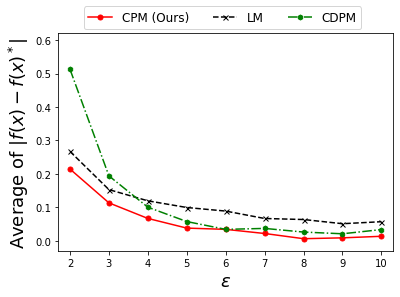

In [6]:
m = 1

diff = np.zeros((9,3))
max_diff = np.zeros((9,3)); min_diff = np.zeros((9,3))
sum_diff = np.zeros((9,3))

jj = 100
for j in range(jj):
    diff = accuracy(m)
    for i in range(9):
        for k in range(3):
            max_diff[i][k] = max(max_diff[i][k], diff[i][k])
            min_diff[i][k] = min(min_diff[i][k], diff[i][k])
            sum_diff[i][k] += diff[i][k]
    print(diff)
diff = sum_diff/jj

y_err = np.zeros((2,9,3))
for k in range(3):
    y_err[0,:,k] = diff[:,k] - min_diff[:,k]
    y_err[1,:,k] = max_diff[:,k] - diff[:,k]
    
epsilon = [i+2 for i in range(9)]

print(diff)
fig = plt.figure()
plt.ylim(-0.03, 0.62)
plt.xlim(1.7, 10.3)
plt.plot(epsilon, diff[:,0], marker="o", markersize=5, color = "red", linestyle = "-", label = "CPM (Ours)")
plt.plot(epsilon, diff[:,1], marker="x", markersize=5, color = "black", linestyle = "dashed", label = "LM")
plt.plot(epsilon, diff[:,2], marker="h", markersize=5, color = "green", linestyle = "dashdot", label = "CDPM")
#plt.errorbar(epsilon, diff[:,0], yerr = y_err[:,:,0], capsize=5, fmt='o', ecolor='red', markeredgecolor = "red", color='red')
#plt.errorbar(epsilon, diff[:,1], yerr = y_err[:,:,1], capsize=5, fmt='x', ecolor='black', markeredgecolor = "black", color='black')
#plt.errorbar(epsilon, diff[:,2], yerr = y_err[:,:,2], capsize=5, fmt='h', ecolor='green', markeredgecolor = "green", color='green')
plt.legend(bbox_to_anchor=(0.49, 1.02), loc='lower center', borderaxespad=0, ncol=3, fontsize=12)
plt.xlabel("$\epsilon$", fontsize = 18)
plt.ylabel("Average of $|f(x) - f(x)^*|$", fontsize = 18)
fig.savefig("Accuracy_single_m=1.png")
fig.savefig("figs/Accuracy_single_m=1.eps", bbox_inches="tight", pad_inches=0.05)